# Background

This notebook does some background exploration for the ERPscanr project. 

Specifically, here we examine some properties of the literature in terms of which methods are used, and how popular ERP research is. 

In [1]:
%matplotlib inline

import csv
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lisc.collect import collect_info, collect_counts
from lisc.plts.utils import get_cmap
from lisc.plts.words import plot_years
from lisc.plts.counts import plot_matrix

In [2]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_year_comparison

## Settings

Settings for the current collection & analyses.

Note that to re-run this notebook, it assumes the same relative structure as the project repository, including the data directory. 

In [3]:
# Notebook settings
SAVE_FIG = False
SAVE_DATA = False
RUN_COLLECTION = False

In [4]:
# Set the location of the data directory 
data_dir = Path('../data/data/background')
figs_dir = Path('../data/figures/background')

In [5]:
# Plot settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

## Meta Data

Collect meta data information about the database we're collecting from, as a log for the collections in this notebook.

In [6]:
# Collect meta data information for current collections
if RUN_COLLECTION:
    meta_data = collect_info()
    
    # Save out meta data information
    if SAVE_DATA:
        with open(data_dir / 'meta_data.json', 'w') as save_file:
            json.dump(meta_data.as_dict(), save_file)

else:
    with open(data_dir / 'meta_data.json', 'r') as f_obj:
        meta_data = json.load(f_obj)

In [7]:
# Check the meta data for the collection
meta_data

{'date': '2021-05-31_10:51:32',
 'log': None,
 'requester_n_requests': 1,
 'requester_wait_time': 0.3333333333333333,
 'requester_start_time': '10:51:32 Monday 31 May 2021',
 'requester_end_time': '10:51:33 Monday 31 May 2021',
 'requester_logging': None,
 'db_info_dbname': 'pubmed',
 'db_info_menuname': 'PubMed',
 'db_info_description': 'PubMed bibliographic record',
 'db_info_dbbuild': 'Build210530-1333.1',
 'db_info_count': '32606554',
 'db_info_lastupdate': '2021/05/30 18:23'}

## Modalities

First, lets collect some basic information on different recording modalities.s

In [8]:
# Define a list of modalities of interest, with synonyms
modality_terms = [['EEG', 'electroencephalography'], 
                  ['MEG', 'magnetoencephalography'], 
                  ['ECoG', 'electrocorticography','iEEG', 'intracranial EEG'],
                  ['fMRI', 'functional magnetic resonance imaging']]

# Define a list of labels to use for the method terms
modality_labels = [lst[0] for lst in modality_terms]

In [9]:
# Collect data for the number of papers found for each method
if RUN_COLLECTION:
    modality_count, _ = collect_counts(modality_terms, collect_coocs=False)
    
    # Save out the collected data for the modality counts
    if SAVE_DATA:
        with open(data_dir / 'method_counts.csv', 'w') as save_file:
            for label, count in zip(modality_labels, modality_count):
                save_file.write(label + ',' + str(count) +'\n')

else:
    with open(data_dir / 'method_counts.csv', 'r') as f_obj:
        modality_count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')

In [10]:
# Check the number of articles found for each modality
print('Number of articles found for each method:')
for label, count in zip(modality_labels, modality_count):
    print('\t', label, '\t', count)

Number of articles found for each method:
	 EEG 	 97580
	 MEG 	 10849
	 ECoG 	 10842
	 fMRI 	 60060


## Modalities Across Time

Next, we can examine the different modalities across time. 

To do so, we will re-run the same search as above, repeated for recent decades, to compare modalities across time.

In [11]:
# Define the range of the decades to collect information on
start_decade, end_decade = 1950, 2020
decades = list(range(start_decade, end_decade, 10))

In [12]:
# Collect information across each decade of interest
if RUN_COLLECTION:
    
    decade_counts = []
    for start_year in decades:

        count, _ = collect_counts(modality_terms,
                                  collect_coocs=False,
                                  mindate=str(start_year) + '/01/01',
                                  maxdate=str(start_year+9) + '/12/31')
        decade_counts.append(count)

    # Convert the collected data into an array, of [n_terms, decade_counts]
    decade_counts = np.array(decade_counts).T
    
    if SAVE_DATA:
        # Save out the collected data for the method counts by decade
        for ind, label in enumerate(modality_labels):
            for decade, count in zip(decades, decade_counts):
                with open(data_dir / 'decades' / (label + '.csv'), 'w') as save_file:
                    for decade, count in zip(decades, decade_counts[ind, :]):
                        save_file.write(str(decade) + ',' + str(count) +'\n')
                        
else:
    decade_counts = []
    for m_term in modality_labels:
        with open(data_dir / 'decades'/ (m_term + '.csv'), 'r') as f_obj:
            count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')
        decade_counts.append(count)
    decade_counts = np.array(decade_counts)

In [13]:
# Check the sum of the methods across decades
#   Note that this should approximate the total counts from above
print('Number of articles, collapsed across years, for each method:')
for label, count in zip(modality_labels, np.sum(decade_counts, 1)):
    print('\t', label, '\t', count)

Number of articles, collapsed across years, for each method:
	 EEG 	 89547
	 MEG 	 9925
	 ECoG 	 9440
	 fMRI 	 54075


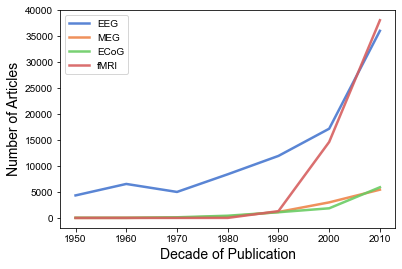

In [14]:
# Plot the popularity of each modality across the decades
plot_year_comparison(decades, decade_counts, modality_labels,
                     save_fig=SAVE_FIG, file_name='modality_decades.pdf', directory=figs_dir)

## Number of ERP Papers

Next, lets examine ERP research. First, we can collect the total number of papers that discuss ERPs.

In [15]:
# Define ERP related search term
erp_term = [["event related potential", "ERP", "evoked potential"]]

In [16]:
# Collect count of the number of papers mentioning ERPs
if RUN_COLLECTION:
    erp_count, meta_data = collect_counts(erp_term, collect_coocs=False)
    
    if SAVE_DATA:        
        # Save out the collected data for the ERP count
        with open(data_dir / 'erp_count.csv', 'w') as save_file:
            save_file.write('erps' + ',' + str(erp_count[0]) +'\n')

else:
    with open(data_dir / 'erp_count.csv', 'r') as f_obj:
        erp_count = np.array([row[1] for row in csv.reader(f_obj)], dtype='int')

In [17]:
# Check the total number of ERP papers found
print('Number of ERP papers: \t', erp_count[0])

Number of ERP papers: 	 34312


## ERP research across years

Next, we can examine ERP research across time, by collecting the number of papers discussing ERPs, per year.

In [18]:
# Define range of years to collect data for
start_year, end_year = 1960, 2021

In [19]:
# Collect count of the number of ERP related papers per year
if RUN_COLLECTION:
    
    year_counts = {}
    for year in range(start_year, end_year):
        temp_count, _ = collect_counts(erp_term, collect_coocs=False, 
                                       mindate=str(year) + '/01/01',
                                       maxdate=str(year) + '/12/31')
        year_counts[year] = temp_count[0]
        
    # Save out the collected data for the method counts by decade
    if SAVE_DATA:
        with open(data_dir / 'erp_years.csv', 'w') as save_file:
            for year, count in year_counts.items():
                save_file.write(str(year) + ',' + str(count) +'\n')
                
else:
    with open(data_dir / 'erp_years.csv', 'r') as f_obj:
        year_counts = {int(row[0]) : int(row[1]) for row in csv.reader(f_obj)}

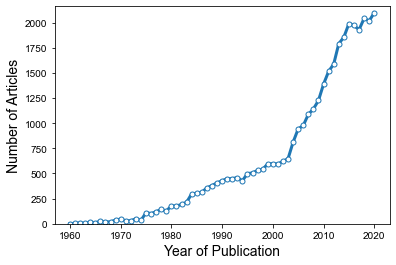

In [20]:
# Plot the number of ERP papers per year
plot_years(year_counts, fontsize=14, figsize=(6, 4),
           save_fig=SAVE_FIG, file_name='erp_years.pdf', directory=figs_dir)

## ERP Associations

Finally, we can do a quick scan of some common general associations of ERP-related work. 

To do so, we will define some very general association terms, and see how often these terms co-occur with ERP research.

In [21]:
# Define some general association terms
assoc_terms = [['cognition', 'cognitive'],
               ['biomarker', 'disease'], 
               ['BCI', 'BCIs', 'brain computer interface'], 
               ['education', 'pedagogy', 'classroom'],
               ['consumer', 'dry-EEG', 'wireless', 'mobile']]

# Define a list of labels to use for the association terms
assoc_labels = [term[0] for term in assoc_terms]

In [22]:
# Collect counts of the number of ERP papers that co-occur with general association terms
if RUN_COLLECTION:
    coocs, counts, meta_data = collect_counts(erp_term, terms_b=assoc_terms)
    
    # Save out the collected data for the association counts
    if SAVE_DATA:
        with open(data_dir / 'association_counts.csv', 'w') as save_file:
            for label, count in zip(assoc_labels, coocs[0, :]):
                save_file.write(label + ',' + str(count) +'\n')
                
else:
    with open(data_dir / 'association_counts.csv', 'r') as f_obj:
        coocs =np.reshape(np.array([row[1] for row in csv.reader(f_obj)], dtype='int'), (-1, 1)).T

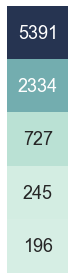

In [23]:
# Plot a visualization the counts of ERP papers per association topic
plot_matrix(coocs.T, [], [], cmap='blue', figsize=(1.15, 4),
            cbar=False, annot=True, annot_kws={"size": 18}, fmt='d', 
            save_fig=SAVE_FIG, file_name='erp_associations.pdf', directory=figs_dir)

## Conclusion

From these background checks, we can see that EEG research, and in particular ERP research is and continues to be popular, and is used in broad areas of research. This motivates the rest of the project - to dig into the ERP litarature, and further characterize it.